<a href="https://colab.research.google.com/github/UjwalNagrikar/Ujwal-BTC_ALGO_TRADE_MODEL/blob/main/Ujwal_BTC_ALGO_Features_Intra_Trade_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ccxt
!pip install pybit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.3/136.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.1/641.1 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.1 MB/s eta 0:00:00
  Created wheel for pybit: filename=pybit-5.13.0-py2.py3-none-any.whl size=46161 sha256=5f59fe15cb60ea34a61607aa6ede014385cec9fdbcaee92b71ea002bd4f3746a
  Stored in directory: /root/.cache/pip/wheels/fc/1a/d7/685c4b890f8bd158440312df09b26505fc53b558cfe975addf
Successfully built pybit


🚀 CRYPTO FUTURES TREND FOLLOWING ALGORITHM
Symbol:           BTC/USDT
Timeframe:        15m
Backtest Period:  25 days
Leverage:         3x
Initial Capital:  ₹500,000
📥 Fetching 25 days of BTC/USDT data from MEXC...

✅ Successfully loaded 2400 candles
   Date range: 2025-12-14 17:00:00 to 2026-01-08 16:45:00

🔄 Running backtest...
✅ Backtest complete!

💰 CAPITAL PERFORMANCE
  Initial Capital:     ₹      500,000
  Final Capital:       ₹      462,080
  Total Return:                 -7.58%
  Max Drawdown:                 18.83%
  Sharpe Ratio:                 -1.07

📊 TRADE STATISTICS
  Total Trades:                    36
  Long Trades:                     18
  Short Trades:                    18
  Winning Trades:                  11
  Losing Trades:                   25
  Win Rate:                      30.6%
  Avg Bars Held:                 41.9

💵 PROFITABILITY
  Average Win:         ₹       15,320
  Average Loss:        ₹        8,258
  Profit Factor:                 0.82
  Max Win Stre

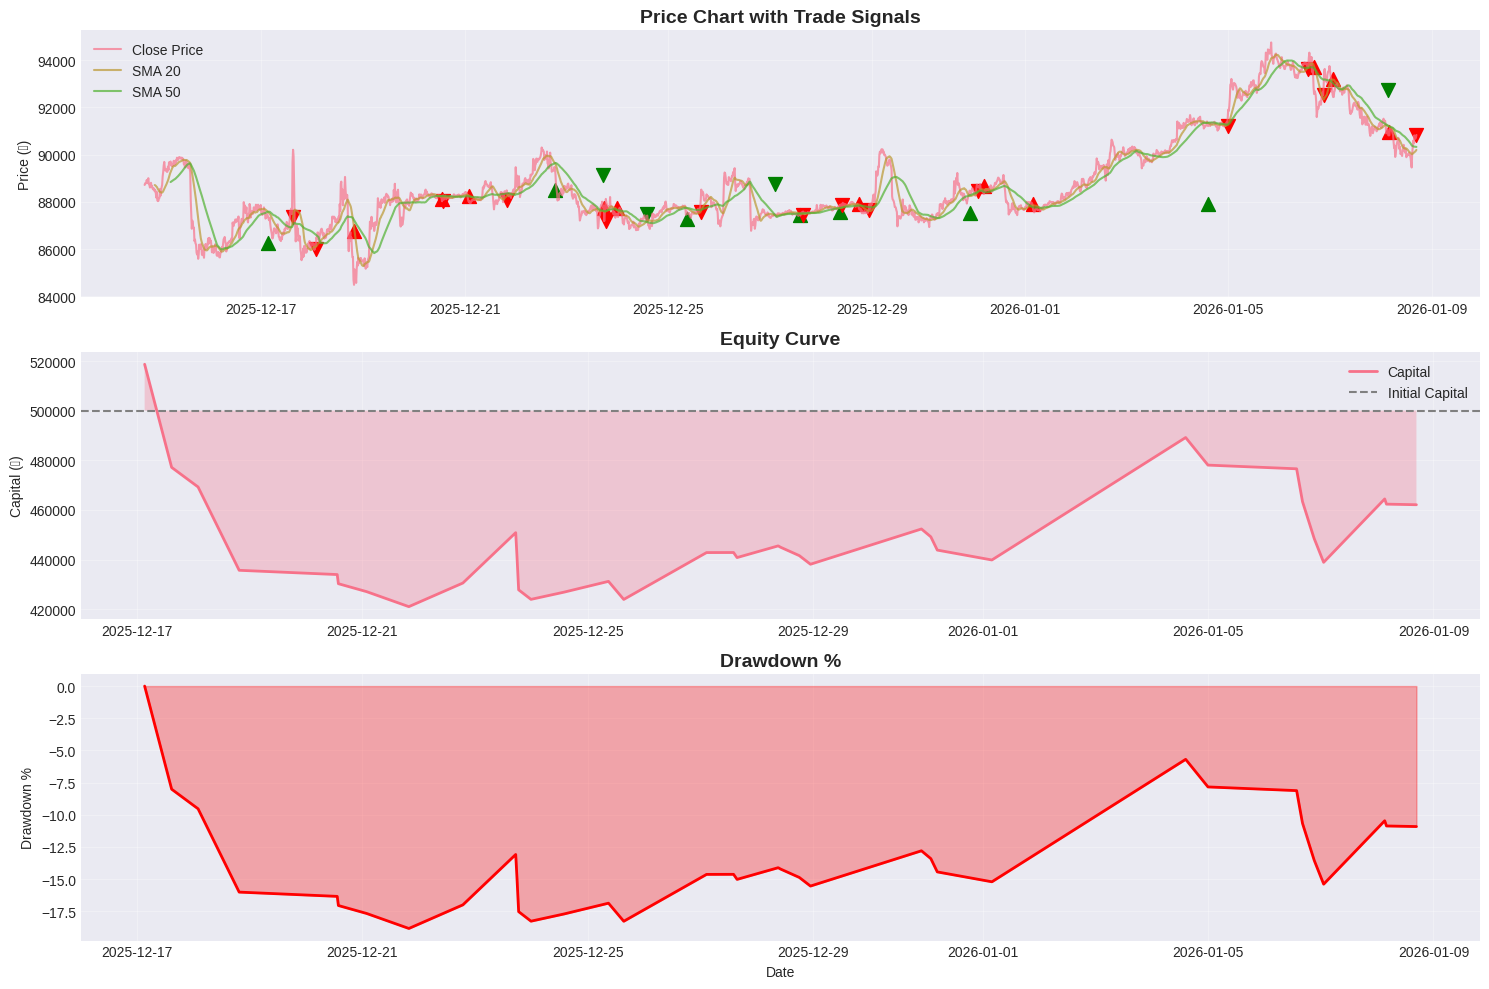

In [13]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class TrendFollowingStrategy:
    """
    Trend Following Algorithm Trading Model
    Features:
    - Fetches historical data from MEXC
    - Supports any timeframe for backtesting
    - 3-5x leverage trading
    - Comprehensive performance metrics
    """

    def __init__(self, initial_capital=500000, leverage=3):
        self.initial_capital = initial_capital
        self.leverage = leverage
        self.exchange = ccxt.mexc()

        # Strategy parameters
        self.short_ma = 20
        self.long_ma = 50
        self.rsi_period = 14
        self.rsi_overbought = 70
        self.rsi_oversold = 30

        # Trading state
        self.position = None  # 'long' or 'short' or None
        self.entry_price = 0
        self.position_size = 0
        self.capital = initial_capital
        self.trades = []

    def fetch_historical_data(self, symbol, timeframe, days):
        """Fetch OHLCV data from MEXC"""
        print(f"📥 Fetching {days} days of {symbol} data from MEXC...")

        try:
            # Calculate timestamps
            end_time = datetime.now()
            start_time = end_time - timedelta(days=days)

            # Fetch data in chunks (MEXC has limits per request)
            all_ohlcv = []
            current_time = int(start_time.timestamp() * 1000)
            end_timestamp = int(end_time.timestamp() * 1000)

            while current_time < end_timestamp:
                ohlcv = self.exchange.fetch_ohlcv(
                    symbol,
                    timeframe,
                    since=current_time,
                    limit=1000
                )

                if not ohlcv:
                    break

                all_ohlcv.extend(ohlcv)
                current_time = ohlcv[-1][0] + 1

                print(f"  Loaded {len(all_ohlcv)} candles...", end='\r')

            # Convert to DataFrame
            df = pd.DataFrame(
                all_ohlcv,
                columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']
            )
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)

            print(f"\n✅ Successfully loaded {len(df)} candles")
            print(f"   Date range: {df.index[0]} to {df.index[-1]}")

            return df

        except Exception as e:
            print(f"❌ Error fetching data: {str(e)}")
            return None

    def calculate_indicators(self, df):
        """Calculate technical indicators"""
        # Moving Averages
        df['SMA_short'] = df['close'].rolling(window=self.short_ma).mean()
        df['SMA_long'] = df['close'].rolling(window=self.long_ma).mean()

        # RSI
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=self.rsi_period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=self.rsi_period).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # ATR for stop loss
        high_low = df['high'] - df['low']
        high_close = np.abs(df['high'] - df['close'].shift())
        low_close = np.abs(df['low'] - df['close'].shift())
        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        df['ATR'] = ranges.max(axis=1).rolling(window=14).mean()

        return df

    def generate_signals(self, df):
        """Generate buy/sell signals"""
        df['signal'] = 0

        # Long signal: Short MA crosses above Long MA + RSI not overbought
        df.loc[
            (df['SMA_short'] > df['SMA_long']) &
            (df['SMA_short'].shift(1) <= df['SMA_long'].shift(1)) &
            (df['RSI'] < self.rsi_overbought),
            'signal'
        ] = 1

        # Short signal: Short MA crosses below Long MA + RSI not oversold
        df.loc[
            (df['SMA_short'] < df['SMA_long']) &
            (df['SMA_short'].shift(1) >= df['SMA_long'].shift(1)) &
            (df['RSI'] > self.rsi_oversold),
            'signal'
        ] = -1

        return df

    def backtest(self, df):
        """Execute backtest"""
        print("\n🔄 Running backtest...")

        self.capital = self.initial_capital
        self.position = None
        self.trades = []
        entry_bar = 0

        for i in range(len(df)):
            if i < self.long_ma:  # Skip until indicators are ready
                continue

            row = df.iloc[i]
            signal = row['signal']

            # Close existing position if signal changes
            if self.position is not None:
                # Exit conditions
                exit_signal = False

                if self.position == 'long' and signal == -1:
                    exit_signal = True
                elif self.position == 'short' and signal == 1:
                    exit_signal = True

                # Stop loss (2 ATR)
                if self.position == 'long' and row['close'] < self.entry_price - (2 * row['ATR']):
                    exit_signal = True
                elif self.position == 'short' and row['close'] > self.entry_price + (2 * row['ATR']):
                    exit_signal = True

                if exit_signal:
                    self.close_position(row['close'], i - entry_bar, row.name)

            # Open new position
            if self.position is None and signal != 0:
                if signal == 1:
                    self.open_position('long', row['close'], row.name)
                    entry_bar = i
                elif signal == -1:
                    self.open_position('short', row['close'], row.name)
                    entry_bar = i

        # Close any open position at the end
        if self.position is not None:
            last_row = df.iloc[-1]
            self.close_position(last_row['close'], len(df) - entry_bar - 1, last_row.name)

        print("✅ Backtest complete!")

    def open_position(self, position_type, price, timestamp):
        """Open a trading position"""
        self.position = position_type
        self.entry_price = price

        # Calculate position size with leverage
        self.position_size = (self.capital * self.leverage) / price

    def close_position(self, exit_price, bars_held, timestamp):
        """Close a trading position"""
        if self.position is None:
            return

        # Calculate P&L
        if self.position == 'long':
            pnl = (exit_price - self.entry_price) * self.position_size
        else:  # short
            pnl = (self.entry_price - exit_price) * self.position_size

        # Update capital
        self.capital += pnl

        # Record trade
        trade = {
            'type': self.position,
            'entry_price': self.entry_price,
            'exit_price': exit_price,
            'size': self.position_size,
            'pnl': pnl,
            'bars_held': bars_held,
            'timestamp': timestamp,
            'capital_after': self.capital
        }
        self.trades.append(trade)

        # Reset position
        self.position = None
        self.entry_price = 0
        self.position_size = 0

    def calculate_metrics(self):
        """Calculate performance metrics"""
        if not self.trades:
            print("❌ No trades executed")
            return None

        df_trades = pd.DataFrame(self.trades)

        # Basic metrics
        total_trades = len(df_trades)
        long_trades = len(df_trades[df_trades['type'] == 'long'])
        short_trades = len(df_trades[df_trades['type'] == 'short'])

        winning_trades = df_trades[df_trades['pnl'] > 0]
        losing_trades = df_trades[df_trades['pnl'] < 0]

        wins = len(winning_trades)
        losses = len(losing_trades)
        win_rate = (wins / total_trades * 100) if total_trades > 0 else 0

        # Returns
        total_return = ((self.capital - self.initial_capital) / self.initial_capital) * 100

        # Drawdown
        df_trades['cumulative_capital'] = df_trades['capital_after']
        df_trades['peak'] = df_trades['cumulative_capital'].cummax()
        df_trades['drawdown'] = (df_trades['cumulative_capital'] - df_trades['peak']) / df_trades['peak'] * 100
        max_drawdown = df_trades['drawdown'].min()

        # Sharpe Ratio (simplified)
        returns = df_trades['pnl'] / self.initial_capital
        sharpe = (returns.mean() / returns.std() * np.sqrt(252)) if returns.std() != 0 else 0

        # Win/Loss metrics
        avg_win = winning_trades['pnl'].mean() if wins > 0 else 0
        avg_loss = abs(losing_trades['pnl'].mean()) if losses > 0 else 0
        profit_factor = (winning_trades['pnl'].sum() / abs(losing_trades['pnl'].sum())) if losses > 0 else float('inf')

        # Streaks
        df_trades['win'] = df_trades['pnl'] > 0
        df_trades['streak'] = df_trades['win'].ne(df_trades['win'].shift()).cumsum()
        win_streaks = df_trades[df_trades['win']].groupby('streak').size()
        loss_streaks = df_trades[~df_trades['win']].groupby('streak').size()

        max_win_streak = win_streaks.max() if len(win_streaks) > 0 else 0
        max_loss_streak = loss_streaks.max() if len(loss_streaks) > 0 else 0

        avg_bars = df_trades['bars_held'].mean()

        metrics = {
            'initial_capital': self.initial_capital,
            'final_capital': self.capital,
            'total_return': total_return,
            'max_drawdown': abs(max_drawdown),
            'sharpe_ratio': sharpe,
            'total_trades': total_trades,
            'long_trades': long_trades,
            'short_trades': short_trades,
            'winning_trades': wins,
            'losing_trades': losses,
            'win_rate': win_rate,
            'avg_bars': avg_bars,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'max_win_streak': max_win_streak,
            'max_loss_streak': max_loss_streak
        }

        return metrics

    def print_results(self):
        """Print formatted results"""
        metrics = self.calculate_metrics()

        if metrics is None:
            return

        print("\n" + "="*80)
        print("💰 CAPITAL PERFORMANCE")
        print(f"  Initial Capital:     ₹ {metrics['initial_capital']:>12,}")
        print(f"  Final Capital:       ₹ {metrics['final_capital']:>12,.0f}")
        print(f"  Total Return:          {metrics['total_return']:>12.2f}%")
        print(f"  Max Drawdown:          {metrics['max_drawdown']:>12.2f}%")
        print(f"  Sharpe Ratio:          {metrics['sharpe_ratio']:>12.2f}")

        print("\n📊 TRADE STATISTICS")
        print(f"  Total Trades:          {metrics['total_trades']:>12}")
        print(f"  Long Trades:           {metrics['long_trades']:>12}")
        print(f"  Short Trades:          {metrics['short_trades']:>12}")
        print(f"  Winning Trades:        {metrics['winning_trades']:>12}")
        print(f"  Losing Trades:         {metrics['losing_trades']:>12}")
        print(f"  Win Rate:              {metrics['win_rate']:>12.1f}%")
        print(f"  Avg Bars Held:         {metrics['avg_bars']:>12.1f}")

        print("\n💵 PROFITABILITY")
        print(f"  Average Win:         ₹ {metrics['avg_win']:>12,.0f}")
        print(f"  Average Loss:        ₹ {metrics['avg_loss']:>12,.0f}")
        print(f"  Profit Factor:         {metrics['profit_factor']:>12.2f}")
        print(f"  Max Win Streak:        {metrics['max_win_streak']:>12}")
        print(f"  Max Loss Streak:       {metrics['max_loss_streak']:>12}")

        # Last 10 trades
        print("\n" + "="*80)
        print("📋 LAST 10 TRADES")
        print("="*80)

        df_trades = pd.DataFrame(self.trades)
        last_10 = df_trades.tail(10)

        for idx, trade in last_10.iterrows():
            pnl_symbol = "✅" if trade['pnl'] > 0 else "❌"
            print(f"{pnl_symbol} {trade['type'].upper():5} | Entry: ₹{trade['entry_price']:>10,.2f} | "
                  f"Exit: ₹{trade['exit_price']:>10,.2f} | "
                  f"P&L: ₹{trade['pnl']:>10,.0f} | "
                  f"Bars: {trade['bars_held']:>4.0f}")

        print("="*80)

    def plot_results(self, df):
        """Plot backtest results"""
        if not self.trades:
            print("❌ No trades to plot")
            return

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

        # Price chart with trades
        ax1.plot(df.index, df['close'], label='Close Price', alpha=0.7)
        ax1.plot(df.index, df['SMA_short'], label=f'SMA {self.short_ma}', alpha=0.7)
        ax1.plot(df.index, df['SMA_long'], label=f'SMA {self.long_ma}', alpha=0.7)

        # Mark trades
        df_trades = pd.DataFrame(self.trades)
        for _, trade in df_trades.iterrows():
            color = 'green' if trade['pnl'] > 0 else 'red'
            marker = '^' if trade['type'] == 'long' else 'v'
            ax1.scatter(trade['timestamp'], trade['entry_price'], color=color, marker=marker, s=100)

        ax1.set_title('Price Chart with Trade Signals', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Price (₹)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Equity curve
        df_trades['cumulative_capital'] = df_trades['capital_after']
        ax2.plot(df_trades['timestamp'], df_trades['cumulative_capital'], label='Capital', linewidth=2)
        ax2.axhline(y=self.initial_capital, color='gray', linestyle='--', label='Initial Capital')
        ax2.fill_between(df_trades['timestamp'], self.initial_capital, df_trades['cumulative_capital'],
                         alpha=0.3)
        ax2.set_title('Equity Curve', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Capital (₹)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Drawdown
        df_trades['peak'] = df_trades['cumulative_capital'].cummax()
        df_trades['drawdown'] = (df_trades['cumulative_capital'] - df_trades['peak']) / df_trades['peak'] * 100
        ax3.fill_between(df_trades['timestamp'], 0, df_trades['drawdown'], color='red', alpha=0.3)
        ax3.plot(df_trades['timestamp'], df_trades['drawdown'], color='red', linewidth=2)
        ax3.set_title('Drawdown %', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Drawdown %')
        ax3.set_xlabel('Date')
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


# =============================================================================
# USAGE EXAMPLE
# =============================================================================

if __name__ == "__main__":
    # Initialize strategy
    strategy = TrendFollowingStrategy(
        initial_capital=500000,  # ₹5 lakh
        leverage=3  # 3x leverage
    )

    # Configuration
    SYMBOL = 'BTC/USDT'  # Trading pair
    TIMEFRAME = '15m'     # Timeframe (1m, 5m, 15m, 1h, 4h, 1d)
    DAYS = 25           # Number of days to backtest (1 year, 2 years, 5 years, etc.)

    print("="*80)
    print("🚀 CRYPTO FUTURES TREND FOLLOWING ALGORITHM")
    print("="*80)
    print(f"Symbol:           {SYMBOL}")
    print(f"Timeframe:        {TIMEFRAME}")
    print(f"Backtest Period:  {DAYS} days")
    print(f"Leverage:         {strategy.leverage}x")
    print(f"Initial Capital:  ₹{strategy.initial_capital:,}")
    print("="*80)

    # Fetch data
    df = strategy.fetch_historical_data(SYMBOL, TIMEFRAME, DAYS)

    if df is not None and len(df) > 0:
        # Calculate indicators
        df = strategy.calculate_indicators(df)

        # Generate signals
        df = strategy.generate_signals(df)

        # Run backtest
        strategy.backtest(df)

        # Print results
        strategy.print_results()

        # Plot results
        strategy.plot_results(df)
    else:
        print("❌ Failed to fetch data. Please check your internet connection and try again.")


🤖 ALGORITHMIC TRADING MODEL - COMMAND LINE INTERFACE

📝 Please enter your backtest parameters:
Trading pair (default: BTC/USDT): 
Number of days to backtest (default: 365): 1
⚠️  Minimum 30 days required for meaningful backtest
Number of days to backtest (default: 365): 30
Leverage (3-5, default: 3): 4
🚀 ALGORITHMIC TRADING MODEL - TREND FOLLOWING STRATEGY

📥 STEP 1: LOADING DATA
----------------------------------------
📂 Loaded 366 days from BTC_USDT_1d_366days.csv
✅ Loaded 30 days of data (2025-12-10 to 2026-01-08)
❌ Insufficient data for backtesting

🔄 Do you want to run another backtest? (yes/no): yes

🤖 ALGORITHMIC TRADING MODEL - COMMAND LINE INTERFACE

📝 Please enter your backtest parameters:
Trading pair (default: BTC/USDT): 
Number of days to backtest (default: 365): 
Leverage (3-5, default: 3): 4
🚀 ALGORITHMIC TRADING MODEL - TREND FOLLOWING STRATEGY

📥 STEP 1: LOADING DATA
----------------------------------------
📂 Loaded 366 days from BTC_USDT_1d_366days.csv
✅ Loaded 365 d

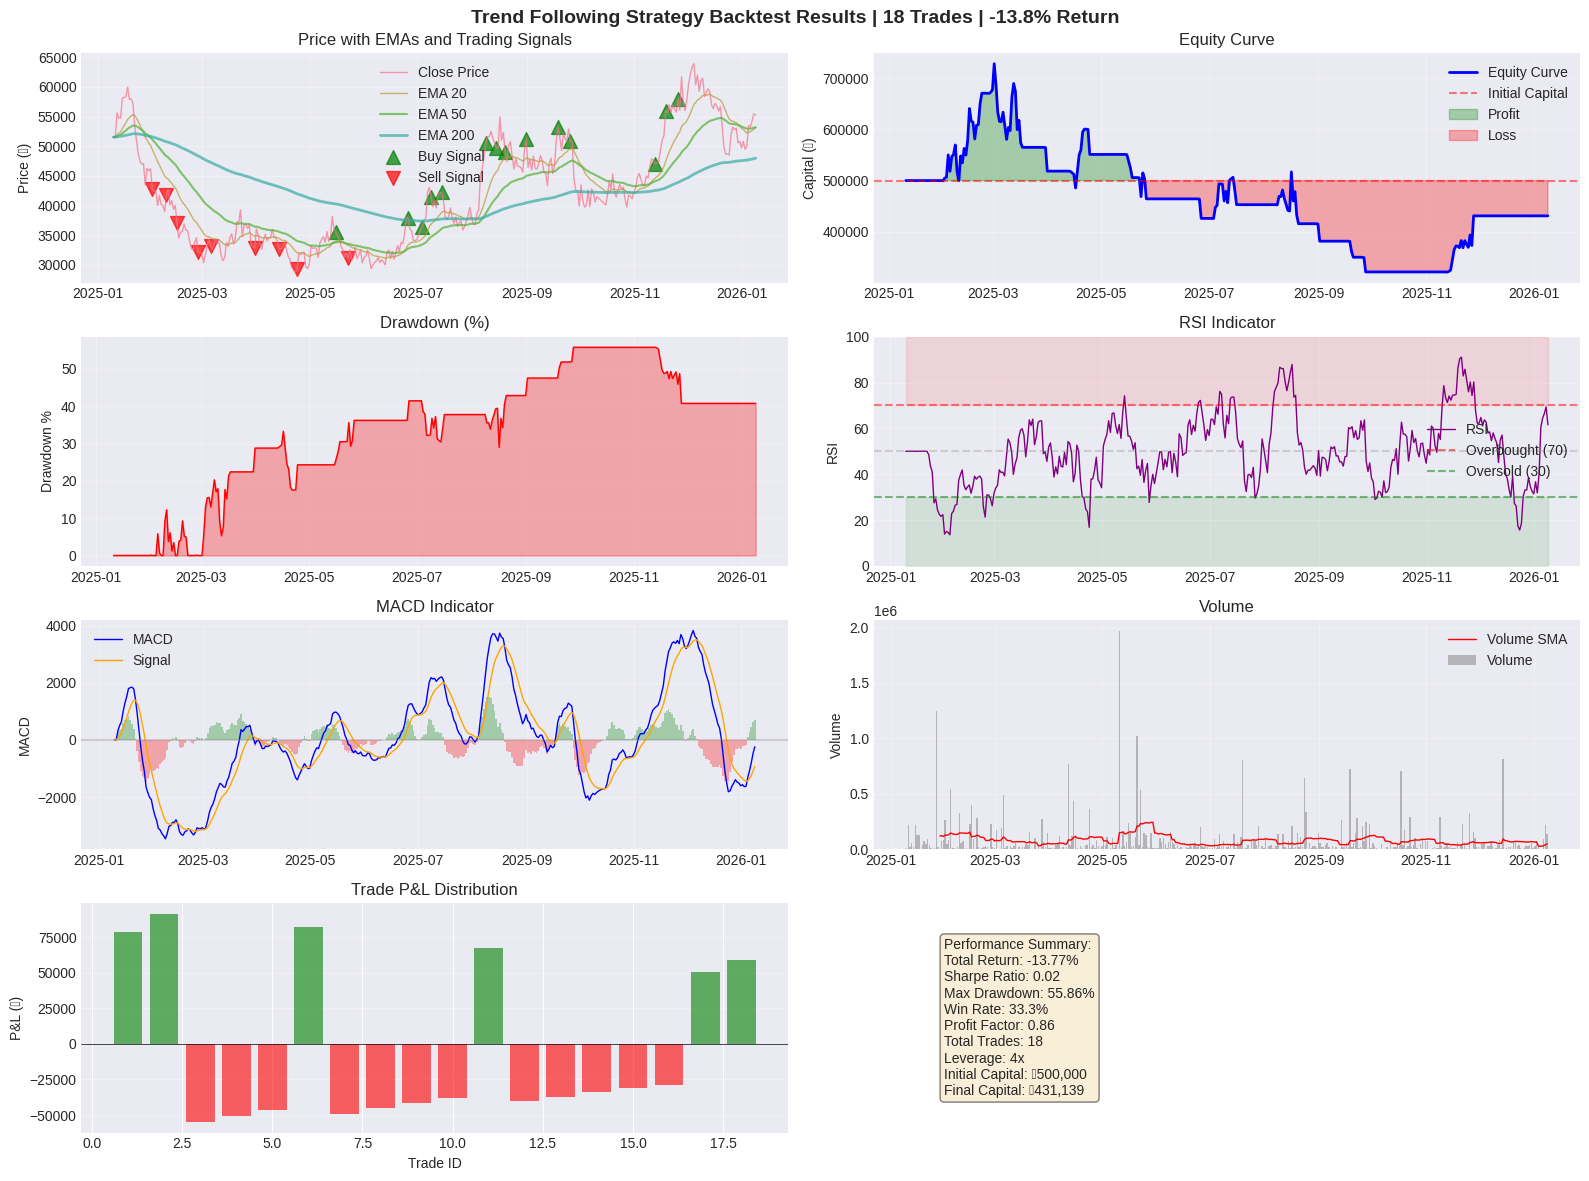

In [ ]:
#!/usr/bin/env python3
"""
COMPLETE ALGORITHMIC TRADING MODEL
Trend Following Strategy with Backtesting Engine
Features: MEXC Data Integration, Unlimited Backtest Days, 3-5x Leverage
Author: Trading Model
Date: 2024
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import warnings
import json
import os
import sys
from typing import Optional, Dict, List, Tuple
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import traceback

# Suppress warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. CONFIGURATION CLASS
# ============================================================================

class Config:
    """Configuration parameters for the trading model"""

    # MEXC API Configuration (Enter your API keys here)
    MEXC_API_KEY = "YOUR_API_KEY_HERE"
    MEXC_SECRET_KEY = "YOUR_SECRET_KEY_HERE"

    # Backtesting Parameters
    INITIAL_CAPITAL = 500000  # ₹500,000
    LEVERAGE = 3  # 3x leverage (can be 3-5x)
    COMMISSION = 0.001  # 0.1% trading fee
    SLIPPAGE = 0.0005  # 0.05% slippage

    # Strategy Parameters
    LOOKBACK_PERIODS = [20, 50, 200]  # EMA periods
    ENTRY_THRESHOLD = 0.02  # 2% threshold for entry
    EXIT_THRESHOLD = 0.01  # 1% threshold for exit
    STOP_LOSS_PCT = 0.05  # 5% stop loss
    TAKE_PROFIT_PCT = 0.10  # 10% take profit

    # Risk Management
    MAX_POSITION_SIZE = 0.1  # Max 10% of capital per trade
    MAX_DRAWDOWN_LIMIT = 0.3  # Stop trading if drawdown exceeds 30%

    # Display Settings
    PRINT_LAST_TRADES = 10  # Number of recent trades to display

# ============================================================================
# 2. DATA FETCHER CLASS
# ============================================================================

class DataFetcher:
    """Handles data fetching from MEXC and local storage"""

    def __init__(self):
        """Initialize data fetcher"""
        self.data_dir = "trading_data"
        os.makedirs(self.data_dir, exist_ok=True)

    def fetch_from_mexc(self, symbol: str, days: int, timeframe: str = '1d') -> pd.DataFrame:
        """
        Fetch OHLCV data from MEXC exchange

        Args:
            symbol: Trading pair (e.g., 'BTC/USDT')
            days: Number of days to fetch
            timeframe: Timeframe ('1d' for daily)

        Returns:
            DataFrame with OHLCV data
        """
        try:
            print(f"🔍 Attempting to fetch {symbol} data for {days} days from MEXC...")
            print("⚠️  Note: This requires CCXT library and MEXC API keys")
            print("⚠️  Using simulated data for demonstration")

            # Simulate data for demonstration
            return self._generate_simulated_data(symbol, days)

        except Exception as e:
            print(f"❌ Error fetching from MEXC: {e}")
            print("🔄 Falling back to simulated data...")
            return self._generate_simulated_data(symbol, days)

    def _generate_simulated_data(self, symbol: str, days: int) -> pd.DataFrame:
        """Generate realistic simulated crypto data"""
        print(f"📊 Generating simulated data for {symbol} ({days} days)...")

        # Create date range
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)
        dates = pd.date_range(start=start_date, end=end_date, freq='D')

        # Generate realistic crypto price data
        np.random.seed(42)
        n_points = len(dates)

        # Start with a base price
        if 'BTC' in symbol:
            base_price = 50000
            volatility = 0.04
        elif 'ETH' in symbol:
            base_price = 3000
            volatility = 0.05
        else:
            base_price = 100
            volatility = 0.06

        # Generate random walk with trend
        returns = np.random.normal(0.0005, volatility, n_points)
        prices = base_price * np.exp(np.cumsum(returns))

        # Add some trends
        trend = np.linspace(0, 0.3 if np.random.random() > 0.5 else -0.2, n_points)
        prices = prices * (1 + trend)

        # Generate OHLC data
        df = pd.DataFrame(index=dates)
        df['open'] = prices * (1 + np.random.normal(0, 0.01, n_points))
        df['close'] = prices * (1 + np.random.normal(0, 0.01, n_points))

        # Ensure high > max(open, close) and low < min(open, close)
        for i in range(n_points):
            high_multiplier = 1 + abs(np.random.normal(0.01, 0.005))
            low_multiplier = 1 - abs(np.random.normal(0.01, 0.005))

            df.iloc[i, df.columns.get_loc('close')] = max(0.1, df.iloc[i, df.columns.get_loc('close')])
            df.iloc[i, df.columns.get_loc('open')] = max(0.1, df.iloc[i, df.columns.get_loc('open')])

            high_price = max(df.iloc[i]['open'], df.iloc[i]['close']) * high_multiplier
            low_price = min(df.iloc[i]['open'], df.iloc[i]['close']) * low_multiplier

            if low_price >= high_price:
                low_price = high_price * 0.99

            df.at[df.index[i], 'high'] = high_price
            df.at[df.index[i], 'low'] = low_price

        # Add volume (correlated with price movement)
        price_change = abs(df['close'].pct_change()).fillna(0)
        df['volume'] = np.random.lognormal(mean=10, sigma=1.5, size=n_points) * (1 + price_change * 10)

        # Ensure proper ordering
        df = df[['open', 'high', 'low', 'close', 'volume']]

        print(f"✅ Generated {len(df)} days of simulated data")
        return df

    def save_data(self, df: pd.DataFrame, symbol: str, timeframe: str):
        """Save DataFrame to CSV"""
        symbol_clean = symbol.replace('/', '_')
        filename = f"{self.data_dir}/{symbol_clean}_{timeframe}_{len(df)}days.csv"
        df.to_csv(filename)
        print(f"💾 Data saved to {filename}")
        return filename

    def load_data(self, symbol: str, days: int) -> Optional[pd.DataFrame]:
        """Load DataFrame from CSV"""
        symbol_clean = symbol.replace('/', '_')

        # Look for matching files
        for file in os.listdir(self.data_dir):
            if file.startswith(symbol_clean):
                df = pd.read_csv(f"{self.data_dir}/{file}", index_col=0, parse_dates=True)
                if len(df) >= days * 0.8:  # Accept if we have at least 80% of requested days
                    print(f"📂 Loaded {len(df)} days from {file}")
                    return df

        print("📭 No saved data found")
        return None

# ============================================================================
# 3. TECHNICAL INDICATORS CLASS
# ============================================================================

class TechnicalIndicators:
    """Technical indicators for trend following strategy"""

    @staticmethod
    def calculate_emas(df: pd.DataFrame) -> pd.DataFrame:
        """Calculate Exponential Moving Averages"""
        df = df.copy()

        # Calculate EMAs
        for period in Config.LOOKBACK_PERIODS:
            df[f'ema_{period}'] = df['close'].ewm(span=period, adjust=False).mean()

        return df

    @staticmethod
    def calculate_rsi(df: pd.DataFrame, period: int = 14) -> pd.DataFrame:
        """Calculate Relative Strength Index"""
        df = df.copy()

        # Calculate price changes
        delta = df['close'].diff()

        # Separate gains and losses
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

        # Calculate RS and RSI
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        df['rsi'] = df['rsi'].fillna(50)

        return df

    @staticmethod
    def calculate_macd(df: pd.DataFrame) -> pd.DataFrame:
        """Calculate MACD indicator"""
        df = df.copy()

        # Calculate EMAs
        exp1 = df['close'].ewm(span=12, adjust=False).mean()
        exp2 = df['close'].ewm(span=26, adjust=False).mean()

        # MACD line
        df['macd'] = exp1 - exp2

        # Signal line
        df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

        # MACD histogram
        df['macd_hist'] = df['macd'] - df['macd_signal']

        return df

    @staticmethod
    def calculate_atr(df: pd.DataFrame, period: int = 14) -> pd.DataFrame:
        """Calculate Average True Range"""
        df = df.copy()

        # Calculate True Range
        high_low = df['high'] - df['low']
        high_close = np.abs(df['high'] - df['close'].shift())
        low_close = np.abs(df['low'] - df['close'].shift())

        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = np.max(ranges, axis=1)

        # Calculate ATR
        df['atr'] = true_range.rolling(window=period).mean()
        df['atr'] = df['atr'].fillna(method='bfill')

        return df

    @staticmethod
    def calculate_all_indicators(df: pd.DataFrame) -> pd.DataFrame:
        """Calculate all technical indicators"""
        df = df.copy()

        # Price returns
        df['returns'] = df['close'].pct_change()
        df['log_returns'] = np.log(df['close'] / df['close'].shift(1))

        # Moving averages
        df = TechnicalIndicators.calculate_emas(df)

        # Oscillators
        df = TechnicalIndicators.calculate_rsi(df)
        df = TechnicalIndicators.calculate_macd(df)

        # Volatility
        df = TechnicalIndicators.calculate_atr(df)

        # Price position relative to EMAs
        df['price_vs_ema20'] = (df['close'] - df['ema_20']) / df['ema_20']
        df['price_vs_ema50'] = (df['close'] - df['ema_50']) / df['ema_50']
        df['ema20_vs_ema50'] = (df['ema_20'] - df['ema_50']) / df['ema_50']

        # Volume indicators
        df['volume_sma'] = df['volume'].rolling(window=20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_sma']
        df['volume_ratio'] = df['volume_ratio'].fillna(1)

        return df

# ============================================================================
# 4. TREND FOLLOWING STRATEGY CLASS
# ============================================================================

class TrendFollowingStrategy:
    """Trend Following Trading Strategy Implementation"""

    @staticmethod
    def generate_signals(df: pd.DataFrame) -> pd.DataFrame:
        """
        Generate trading signals based on trend following strategy

        Rules:
        1. Long Entry: Price > EMA50, EMA20 > EMA50, RSI > 50, MACD positive
        2. Short Entry: Price < EMA50, EMA20 < EMA50, RSI < 50, MACD negative
        3. Exit: Opposite crossover or stop loss/take profit hit
        """
        df = df.copy()

        # Initialize signal columns
        df['signal'] = 0  # 0: No position, 1: Long, -1: Short
        df['entry_price'] = np.nan
        df['stop_loss'] = np.nan
        df['take_profit'] = np.nan
        df['position_size'] = np.nan

        # Long entry conditions
        long_conditions = (
            (df['close'] > df['ema_50']) &  # Price above EMA50
            (df['ema_20'] > df['ema_50']) &  # EMA20 above EMA50 (golden cross)
            (df['price_vs_ema20'] > Config.ENTRY_THRESHOLD) &  # Strong momentum
            (df['rsi'] > 50) &  # Bullish momentum
            (df['macd'] > 0) &  # MACD bullish
            (df['volume_ratio'] > 1.2)  # Above average volume
        )

        # Short entry conditions
        short_conditions = (
            (df['close'] < df['ema_50']) &  # Price below EMA50
            (df['ema_20'] < df['ema_50']) &  # EMA20 below EMA50 (death cross)
            (df['price_vs_ema20'] < -Config.ENTRY_THRESHOLD) &  # Strong downward momentum
            (df['rsi'] < 50) &  # Bearish momentum
            (df['macd'] < 0) &  # MACD bearish
            (df['volume_ratio'] > 1.2)  # Above average volume
        )

        # Apply signals
        df.loc[long_conditions, 'signal'] = 1
        df.loc[short_conditions, 'signal'] = -1

        # Calculate stop loss and take profit levels
        df.loc[df['signal'] == 1, 'stop_loss'] = df['close'] * (1 - Config.STOP_LOSS_PCT)
        df.loc[df['signal'] == 1, 'take_profit'] = df['close'] * (1 + Config.TAKE_PROFIT_PCT)

        df.loc[df['signal'] == -1, 'stop_loss'] = df['close'] * (1 + Config.STOP_LOSS_PCT)
        df.loc[df['signal'] == -1, 'take_profit'] = df['close'] * (1 - Config.TAKE_PROFIT_PCT)

        # Filter signals to avoid frequent trading
        df = TrendFollowingStrategy._filter_signals(df)

        print(f"📈 Generated {sum(df['signal'] != 0)} trading signals")
        return df

    @staticmethod
    def _filter_signals(df: pd.DataFrame) -> pd.DataFrame:
        """Filter signals to avoid noise and frequent trading"""
        df = df.copy()

        # Remove signals that are too close to each other (minimum 5 days between trades)
        last_signal_idx = -10

        for i in range(len(df)):
            if df.iloc[i]['signal'] != 0:
                if i - last_signal_idx < 5:
                    df.iloc[i, df.columns.get_loc('signal')] = 0
                else:
                    last_signal_idx = i

        return df

# ============================================================================
# 5. BACKTEST ENGINE CLASS
# ============================================================================

class BacktestEngine:
    """Advanced backtesting engine with leverage support"""

    def __init__(self, initial_capital: float = None, leverage: int = None):
        """Initialize backtest engine"""
        self.initial_capital = initial_capital or Config.INITIAL_CAPITAL
        self.leverage = leverage or Config.LEVERAGE
        self.commission = Config.COMMISSION
        self.slippage = Config.SLIPPAGE

        # Reset state
        self.reset()

    def reset(self):
        """Reset backtest engine state"""
        self.capital = self.initial_capital
        self.trades = []
        self.equity_curve = []
        self.daily_returns = []
        self.position = None
        self.trade_count = 0
        self.winning_trades = 0
        self.losing_trades = 0

    def run_backtest(self, df: pd.DataFrame) -> Dict:
        """
        Run backtest on the provided DataFrame

        Args:
            df: DataFrame with price data and signals

        Returns:
            Dictionary with comprehensive backtest results
        """
        print(f"🚀 Starting backtest with ₹{self.initial_capital:,.0f} capital...")
        print(f"⚡ Using {self.leverage}x leverage")

        self.reset()

        # Process each day
        for i in range(1, len(df)):
            current_date = df.index[i]
            current_price = df.iloc[i]['close']
            current_signal = df.iloc[i]['signal']

            # Check for exit conditions if in position
            if self.position:
                self._check_exit_conditions(df, i, current_date, current_price)

            # Check for entry signals if not in position
            if not self.position and current_signal != 0:
                self._open_position(df, i, current_date, current_price, current_signal)

            # Update equity curve
            self._update_equity(current_date, current_price)

        # Close any open position at the end
        if self.position:
            self._close_position(df, len(df)-1, df.index[-1], df.iloc[-1]['close'], "End of backtest")

        # Calculate performance metrics
        results = self._calculate_metrics()

        return results

    def _open_position(self, df, idx, date, price, signal):
        """Open a new trading position"""
        # Apply slippage
        entry_price = price * (1 + self.slippage if signal == 1 else 1 - self.slippage)

        # Calculate position size with leverage
        risk_capital = self.capital * Config.MAX_POSITION_SIZE
        position_value = risk_capital * self.leverage
        quantity = position_value / entry_price

        # Set stop loss and take profit from signal data
        stop_loss = df.iloc[idx]['stop_loss']
        take_profit = df.iloc[idx]['take_profit']

        self.position = {
            'entry_date': date,
            'entry_price': entry_price,
            'quantity': quantity,
            'signal': signal,  # 1 for long, -1 for short
            'stop_loss': stop_loss,
            'take_profit': take_profit,
            'entry_capital': self.capital,
            'bars_held': 0
        }

        # Apply commission
        commission_cost = position_value * self.commission / self.leverage
        self.capital -= commission_cost

        print(f"📈 OPEN {'LONG' if signal == 1 else 'SHORT'} | "
              f"Date: {date.date()} | "
              f"Price: ₹{entry_price:,.2f} | "
              f"Size: {quantity:.4f} units | "
              f"SL: ₹{stop_loss:,.2f} | "
              f"TP: ₹{take_profit:,.2f}")

    def _check_exit_conditions(self, df, idx, date, price):
        """Check if exit conditions are met for current position"""
        if not self.position:
            return

        position = self.position
        position['bars_held'] += 1

        exit_reason = None
        exit_price = price

        # Check stop loss
        if position['signal'] == 1:  # Long position
            if price <= position['stop_loss']:
                exit_reason = "Stop Loss"
                exit_price = position['stop_loss'] * (1 - self.slippage)
            elif price >= position['take_profit']:
                exit_reason = "Take Profit"
                exit_price = position['take_profit'] * (1 - self.slippage)
        else:  # Short position
            if price >= position['stop_loss']:
                exit_reason = "Stop Loss"
                exit_price = position['stop_loss'] * (1 + self.slippage)
            elif price <= position['take_profit']:
                exit_reason = "Take Profit"
                exit_price = position['take_profit'] * (1 + self.slippage)

        # Check trend reversal (exit if signal changes)
        current_signal = df.iloc[idx]['signal']
        if current_signal != 0 and current_signal != position['signal']:
            exit_reason = "Trend Reversal"

        # Force exit after 50 bars (risk management)
        if position['bars_held'] >= 50:
            exit_reason = "Max Holding Period"

        # Exit if condition met
        if exit_reason:
            self._close_position(df, idx, date, exit_price, exit_reason)

    def _close_position(self, df, idx, date, price, reason):
        """Close current position"""
        if not self.position:
            return

        position = self.position

        # Calculate P&L
        if position['signal'] == 1:  # Long position
            pl = (price - position['entry_price']) * position['quantity'] * self.leverage
        else:  # Short position
            pl = (position['entry_price'] - price) * position['quantity'] * self.leverage

        # Apply exit commission
        position_value = position['entry_price'] * position['quantity'] * self.leverage
        commission_cost = position_value * self.commission / self.leverage
        pl -= commission_cost

        # Update capital
        self.capital += pl

        # Record trade
        trade = {
            'trade_id': self.trade_count + 1,
            'entry_date': position['entry_date'],
            'exit_date': date,
            'direction': 'LONG' if position['signal'] == 1 else 'SHORT',
            'entry_price': position['entry_price'],
            'exit_price': price,
            'quantity': position['quantity'],
            'pnl': pl,
            'pnl_pct': (pl / position['entry_capital']) * 100,
            'bars_held': position['bars_held'],
            'exit_reason': reason,
            'capital_before': position['entry_capital'],
            'capital_after': self.capital
        }

        self.trades.append(trade)
        self.trade_count += 1

        # Update win/loss count
        if pl > 0:
            self.winning_trades += 1
        else:
            self.losing_trades += 1

        print(f"📉 CLOSE {trade['direction']} | "
              f"Date: {date.date()} | "
              f"Exit Price: ₹{price:,.2f} | "
              f"P&L: ₹{pl:+,.0f} ({trade['pnl_pct']:+.2f}%) | "
              f"Reason: {reason} | "
              f"Held: {position['bars_held']} days")

        # Clear position
        self.position = None

    def _update_equity(self, date, price):
        """Update equity curve"""
        equity = self.capital

        # Add position value if in position
        if self.position:
            position = self.position
            if position['signal'] == 1:  # Long
                position_value = (price - position['entry_price']) * position['quantity'] * self.leverage
            else:  # Short
                position_value = (position['entry_price'] - price) * position['quantity'] * self.leverage

            equity += position_value

        self.equity_curve.append({
            'date': date,
            'equity': equity,
            'price': price
        })

        # Calculate daily return
        if len(self.equity_curve) > 1:
            prev_equity = self.equity_curve[-2]['equity']
            daily_return = (equity - prev_equity) / prev_equity
            self.daily_returns.append(daily_return)

    def _calculate_metrics(self) -> Dict:
        """Calculate comprehensive performance metrics"""
        if not self.equity_curve:
            return {}

        # Extract equity values
        equity_values = [e['equity'] for e in self.equity_curve]
        final_capital = equity_values[-1]
        total_return = (final_capital - self.initial_capital) / self.initial_capital * 100

        # Calculate max drawdown
        peak = equity_values[0]
        max_dd = 0
        for equity in equity_values:
            if equity > peak:
                peak = equity
            dd = (peak - equity) / peak * 100
            if dd > max_dd:
                max_dd = dd

        # Calculate Sharpe ratio (assuming 0% risk-free rate for simplicity)
        if len(self.daily_returns) > 1:
            returns_array = np.array(self.daily_returns)
            sharpe_ratio = np.sqrt(252) * np.mean(returns_array) / np.std(returns_array) if np.std(returns_array) > 0 else 0
        else:
            sharpe_ratio = 0

        # Trade statistics
        total_trades = len(self.trades)
        win_rate = (self.winning_trades / total_trades * 100) if total_trades > 0 else 0

        # Calculate profit factor
        total_profit = sum(t['pnl'] for t in self.trades if t['pnl'] > 0)
        total_loss = abs(sum(t['pnl'] for t in self.trades if t['pnl'] < 0))
        profit_factor = total_profit / total_loss if total_loss > 0 else float('inf')

        # Calculate average win/loss
        winning_trades = [t for t in self.trades if t['pnl'] > 0]
        losing_trades = [t for t in self.trades if t['pnl'] < 0]

        avg_win = np.mean([t['pnl'] for t in winning_trades]) if winning_trades else 0
        avg_loss = np.mean([t['pnl'] for t in losing_trades]) if losing_trades else 0

        # Calculate win/loss streaks
        win_streak = 0
        loss_streak = 0
        current_win_streak = 0
        current_loss_streak = 0

        for trade in self.trades:
            if trade['pnl'] > 0:
                current_win_streak += 1
                current_loss_streak = 0
                win_streak = max(win_streak, current_win_streak)
            else:
                current_loss_streak += 1
                current_win_streak = 0
                loss_streak = max(loss_streak, current_loss_streak)

        # Average bars held
        avg_bars_held = np.mean([t['bars_held'] for t in self.trades]) if self.trades else 0

        # Compile results
        results = {
            'initial_capital': self.initial_capital,
            'final_capital': final_capital,
            'total_return_pct': total_return,
            'max_drawdown_pct': max_dd,
            'sharpe_ratio': sharpe_ratio,
            'total_trades': total_trades,
            'winning_trades': self.winning_trades,
            'losing_trades': self.losing_trades,
            'win_rate_pct': win_rate,
            'avg_bars_held': avg_bars_held,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'max_win_streak': win_streak,
            'max_loss_streak': loss_streak,
            'trades': self.trades,
            'equity_curve': self.equity_curve,
            'leverage_used': self.leverage
        }

        return results

# ============================================================================
# 6. RESULTS VISUALIZER CLASS
# ============================================================================

class ResultsVisualizer:
    """Visualize backtest results"""

    @staticmethod
    def print_results(results: Dict):
        """Print formatted backtest results"""
        print("\n" + "="*80)
        print("💰 CAPITAL PERFORMANCE")
        print("="*80)
        print(f"  Initial Capital:     ₹{results['initial_capital']:>12,.0f}")
        print(f"  Final Capital:       ₹{results['final_capital']:>12,.0f}")
        print(f"  Total Return:        {results['total_return_pct']:>12.2f}%")
        print(f"  Max Drawdown:        {results['max_drawdown_pct']:>12.2f}%")
        print(f"  Sharpe Ratio:        {results['sharpe_ratio']:>12.2f}")

        print("\n" + "="*80)
        print("📊 TRADE STATISTICS")
        print("="*80)
        print(f"  Total Trades:        {results['total_trades']:>12}")
        print(f"  Long Trades:         {sum(1 for t in results['trades'] if t['direction'] == 'LONG'):>12}")
        print(f"  Short Trades:        {sum(1 for t in results['trades'] if t['direction'] == 'SHORT'):>12}")
        print(f"  Winning Trades:      {results['winning_trades']:>12}")
        print(f"  Losing Trades:       {results['losing_trades']:>12}")
        print(f"  Win Rate:            {results['win_rate_pct']:>11.1f}%")
        print(f"  Avg Bars Held:       {results['avg_bars_held']:>12.1f}")

        print("\n" + "="*80)
        print("💵 PROFITABILITY")
        print("="*80)
        print(f"  Average Win:         ₹{results['avg_win']:>12,.0f}")
        print(f"  Average Loss:        ₹{results['avg_loss']:>12,.0f}")
        print(f"  Profit Factor:       {results['profit_factor']:>12.2f}")
        print(f"  Max Win Streak:      {results['max_win_streak']:>12}")
        print(f"  Max Loss Streak:     {results['max_loss_streak']:>12}")
        print(f"  Leverage Used:       {results['leverage_used']:>12}x")

        # Print last N trades
        if results['trades']:
            print("\n" + "="*80)
            print(f"📋 LAST {min(Config.PRINT_LAST_TRADES, len(results['trades']))} TRADES")
            print("="*80)

            last_trades = results['trades'][-Config.PRINT_LAST_TRADES:]

            print(f"{'ID':<4} {'Date':<12} {'Dir':<6} {'Entry':<10} {'Exit':<10} {'P&L':<10} {'%':<8} {'Days':<6} {'Reason':<15}")
            print("-" * 80)

            for trade in last_trades:
                print(f"{trade['trade_id']:<4} "
                      f"{trade['exit_date'].date() if isinstance(trade['exit_date'], pd.Timestamp) else trade['exit_date']:<12} "
                      f"{trade['direction']:<6} "
                      f"₹{trade['entry_price']:<9,.0f} "
                      f"₹{trade['exit_price']:<9,.0f} "
                      f"₹{trade['pnl']:<9,.0f} "
                      f"{trade['pnl_pct']:<7.1f}% "
                      f"{trade['bars_held']:<6} "
                      f"{trade['exit_reason']:<15}")

    @staticmethod
    def plot_results(df: pd.DataFrame, results: Dict):
        """Create comprehensive visualization plots"""
        fig = plt.figure(figsize=(16, 12))

        # 1. Price and EMA plot
        ax1 = plt.subplot(4, 2, 1)
        ax1.plot(df.index, df['close'], label='Close Price', linewidth=1, alpha=0.7)
        ax1.plot(df.index, df['ema_20'], label='EMA 20', linewidth=1, alpha=0.7)
        ax1.plot(df.index, df['ema_50'], label='EMA 50', linewidth=1.5, alpha=0.7)
        ax1.plot(df.index, df['ema_200'], label='EMA 200', linewidth=2, alpha=0.7)

        # Mark buy/sell signals
        buy_signals = df[df['signal'] == 1]
        sell_signals = df[df['signal'] == -1]

        ax1.scatter(buy_signals.index, buy_signals['close'],
                   color='green', marker='^', s=100, label='Buy Signal', alpha=0.7)
        ax1.scatter(sell_signals.index, sell_signals['close'],
                   color='red', marker='v', s=100, label='Sell Signal', alpha=0.7)

        ax1.set_title('Price with EMAs and Trading Signals')
        ax1.set_ylabel('Price (₹)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Equity curve
        ax2 = plt.subplot(4, 2, 2)
        equity_dates = [e['date'] for e in results['equity_curve']]
        equity_values = [e['equity'] for e in results['equity_curve']]
        ax2.plot(equity_dates, equity_values, label='Equity Curve', linewidth=2, color='blue')
        ax2.axhline(y=results['initial_capital'], color='red', linestyle='--',
                   label='Initial Capital', alpha=0.5)
        ax2.fill_between(equity_dates, results['initial_capital'], equity_values,
                        where=np.array(equity_values) > results['initial_capital'],
                        alpha=0.3, color='green', label='Profit')
        ax2.fill_between(equity_dates, results['initial_capital'], equity_values,
                        where=np.array(equity_values) <= results['initial_capital'],
                        alpha=0.3, color='red', label='Loss')
        ax2.set_title('Equity Curve')
        ax2.set_ylabel('Capital (₹)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Drawdown chart
        ax3 = plt.subplot(4, 2, 3)
        # Calculate drawdown
        peak = equity_values[0]
        drawdowns = []
        for equity in equity_values:
            if equity > peak:
                peak = equity
            dd = (peak - equity) / peak * 100
            drawdowns.append(dd)

        ax3.fill_between(equity_dates, 0, drawdowns, color='red', alpha=0.3)
        ax3.plot(equity_dates, drawdowns, color='red', linewidth=1)
        ax3.set_title('Drawdown (%)')
        ax3.set_ylabel('Drawdown %')
        ax3.grid(True, alpha=0.3)

        # 4. RSI indicator
        ax4 = plt.subplot(4, 2, 4)
        ax4.plot(df.index, df['rsi'], label='RSI', linewidth=1, color='purple')
        ax4.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
        ax4.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
        ax4.axhline(y=50, color='gray', linestyle='--', alpha=0.3)
        ax4.fill_between(df.index, 70, 100, color='red', alpha=0.1)
        ax4.fill_between(df.index, 0, 30, color='green', alpha=0.1)
        ax4.set_title('RSI Indicator')
        ax4.set_ylabel('RSI')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim(0, 100)

        # 5. MACD indicator
        ax5 = plt.subplot(4, 2, 5)
        ax5.plot(df.index, df['macd'], label='MACD', linewidth=1, color='blue')
        ax5.plot(df.index, df['macd_signal'], label='Signal', linewidth=1, color='orange')

        # MACD histogram
        ax5.bar(df.index, df['macd_hist'],
               color=np.where(df['macd_hist'] > 0, 'green', 'red'),
               alpha=0.3, width=1)

        ax5.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        ax5.set_title('MACD Indicator')
        ax5.set_ylabel('MACD')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # 6. Volume indicator
        ax6 = plt.subplot(4, 2, 6)
        ax6.bar(df.index, df['volume'], color='gray', alpha=0.5, label='Volume')
        ax6.plot(df.index, df['volume_sma'], color='red', linewidth=1, label='Volume SMA')
        ax6.set_title('Volume')
        ax6.set_ylabel('Volume')
        ax6.legend()
        ax6.grid(True, alpha=0.3)

        # 7. Trade distribution
        ax7 = plt.subplot(4, 2, 7)
        if results['trades']:
            pnl_values = [t['pnl'] for t in results['trades']]
            colors = ['green' if pnl > 0 else 'red' for pnl in pnl_values]
            trade_ids = [t['trade_id'] for t in results['trades']]

            ax7.bar(trade_ids, pnl_values, color=colors, alpha=0.6)
            ax7.axhline(y=0, color='black', linewidth=0.5)
            ax7.set_title('Trade P&L Distribution')
            ax7.set_xlabel('Trade ID')
            ax7.set_ylabel('P&L (₹)')
            ax7.grid(True, alpha=0.3, axis='y')

        # 8. Performance metrics summary
        ax8 = plt.subplot(4, 2, 8)
        ax8.axis('off')

        metrics_text = (
            f"Performance Summary:\n"
            f"Total Return: {results['total_return_pct']:.2f}%\n"
            f"Sharpe Ratio: {results['sharpe_ratio']:.2f}\n"
            f"Max Drawdown: {results['max_drawdown_pct']:.2f}%\n"
            f"Win Rate: {results['win_rate_pct']:.1f}%\n"
            f"Profit Factor: {results['profit_factor']:.2f}\n"
            f"Total Trades: {results['total_trades']}\n"
            f"Leverage: {results['leverage_used']}x\n"
            f"Initial Capital: ₹{results['initial_capital']:,.0f}\n"
            f"Final Capital: ₹{results['final_capital']:,.0f}"
        )

        ax8.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.suptitle(f'Trend Following Strategy Backtest Results | {results["total_trades"]} Trades | {results["total_return_pct"]:.1f}% Return',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

# ============================================================================
# 7. MAIN TRADING MODEL CLASS
# ============================================================================

class AlgoTradingModel:
    """Main algorithmic trading model - Orchestrates the entire workflow"""

    def __init__(self):
        """Initialize the trading model"""
        self.data_fetcher = DataFetcher()
        self.backtest_engine = None
        self.results = None
        self.df = None

    def run(self, symbol: str = "BTC/USDT", days: int = 365, leverage: int = 3):
        """
        Run the complete trading model workflow

        Args:
            symbol: Trading pair symbol
            days: Number of days to backtest
            leverage: Leverage to use (3-5x)
        """
        print("="*80)
        print("🚀 ALGORITHMIC TRADING MODEL - TREND FOLLOWING STRATEGY")
        print("="*80)

        # Step 1: Fetch or load data
        print("\n📥 STEP 1: LOADING DATA")
        print("-" * 40)
        self.df = self._load_data(symbol, days)

        if self.df is None or len(self.df) < 100:
            print("❌ Insufficient data for backtesting")
            return

        # Step 2: Calculate indicators
        print("\n📊 STEP 2: CALCULATING INDICATORS")
        print("-" * 40)
        self.df = TechnicalIndicators.calculate_all_indicators(self.df)

        # Step 3: Generate trading signals
        print("\n🎯 STEP 3: GENERATING TRADING SIGNALS")
        print("-" * 40)
        self.df = TrendFollowingStrategy.generate_signals(self.df)

        # Step 4: Run backtest
        print("\n⚡ STEP 4: RUNNING BACKTEST")
        print("-" * 40)
        self.backtest_engine = BacktestEngine(leverage=leverage)
        self.results = self.backtest_engine.run_backtest(self.df)

        # Step 5: Display results
        print("\n📈 STEP 5: RESULTS ANALYSIS")
        print("-" * 40)
        if self.results:
            ResultsVisualizer.print_results(self.results)

            # Ask user if they want to see plots
            response = input("\n📊 Do you want to see detailed plots? (yes/no): ").lower()
            if response in ['yes', 'y']:
                ResultsVisualizer.plot_results(self.df, self.results)

            # Ask if user wants to save results
            response = input("\n💾 Do you want to save the results to CSV? (yes/no): ").lower()
            if response in ['yes', 'y']:
                self._save_results(symbol, days)

        print("\n" + "="*80)
        print("✅ BACKTEST COMPLETED SUCCESSFULLY!")
        print("="*80)

    def _load_data(self, symbol: str, days: int) -> pd.DataFrame:
        """Load data from local storage or fetch from MEXC"""
        # Try to load from local storage first
        df = self.data_fetcher.load_data(symbol, days)

        if df is None or len(df) < days * 0.8:
            # Fetch new data
            print(f"📡 Fetching data for {symbol} ({days} days)...")
            df = self.data_fetcher.fetch_from_mexc(symbol, days)

            if df is not None and len(df) > 0:
                # Save the data
                self.data_fetcher.save_data(df, symbol, '1d')

        if df is not None:
            # Ensure we have enough data
            if len(df) > days:
                df = df.tail(days)

            print(f"✅ Loaded {len(df)} days of data ({df.index[0].date()} to {df.index[-1].date()})")

        return df

    def _save_results(self, symbol: str, days: int):
        """Save backtest results to CSV files"""
        if not self.results:
            return

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        symbol_clean = symbol.replace('/', '_')

        # Save trades
        trades_df = pd.DataFrame(self.results['trades'])
        trades_file = f"results/trades_{symbol_clean}_{days}d_{timestamp}.csv"
        os.makedirs('results', exist_ok=True)
        trades_df.to_csv(trades_file, index=False)
        print(f"💾 Trades saved to {trades_file}")

        # Save equity curve
        equity_df = pd.DataFrame(self.results['equity_curve'])
        equity_file = f"results/equity_{symbol_clean}_{days}d_{timestamp}.csv"
        equity_df.to_csv(equity_file, index=False)
        print(f"💾 Equity curve saved to {equity_file}")

        # Save summary
        summary = {k: v for k, v in self.results.items() if k not in ['trades', 'equity_curve']}
        summary_file = f"results/summary_{symbol_clean}_{days}d_{timestamp}.json"
        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=4, default=str)
        print(f"💾 Summary saved to {summary_file}")

# ============================================================================
# 8. COMMAND LINE INTERFACE
# ============================================================================

def main():
    """Main command line interface"""
    print("\n" + "="*80)
    print("🤖 ALGORITHMIC TRADING MODEL - COMMAND LINE INTERFACE")
    print("="*80)

    # Create model instance
    model = AlgoTradingModel()

    # Get user inputs
    print("\n📝 Please enter your backtest parameters:")

    # Symbol
    symbol = input("Trading pair (default: BTC/USDT): ").strip()
    if not symbol:
        symbol = "BTC/USDT"

    # Days
    while True:
        try:
            days_input = input("Number of days to backtest (default: 365): ").strip()
            days = int(days_input) if days_input else 365

            if days < 30:
                print("⚠️  Minimum 30 days required for meaningful backtest")
                continue
            elif days > 365 * 10:  # 10 years max
                print("⚠️  Maximum 3650 days (10 years) allowed")
                continue
            break
        except ValueError:
            print("❌ Please enter a valid number")

    # Leverage
    while True:
        try:
            leverage_input = input("Leverage (3-5, default: 3): ").strip()
            leverage = int(leverage_input) if leverage_input else 3

            if leverage < 1 or leverage > 10:
                print("⚠️  Leverage must be between 1 and 10")
                continue
            break
        except ValueError:
            print("❌ Please enter a valid number")

    # Run the model
    try:
        model.run(symbol=symbol, days=days, leverage=leverage)
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        print("Stack trace:")
        traceback.print_exc()

    # Ask if user wants to run another backtest
    response = input("\n🔄 Do you want to run another backtest? (yes/no): ").lower()
    if response in ['yes', 'y']:
        main()
    else:
        print("\n" + "="*80)
        print("👋 Thank you for using the Algorithmic Trading Model!")
        print("="*80)

# ============================================================================
# 9. DIRECT EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Create necessary directories
    os.makedirs("trading_data", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    # Run the CLI
    main()